In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../')
from source.interference_reject import InterferenceReject
from source.reader import read_raw
from source.gridding import NFFT
from source.combine import CoilCombo

%matplotlib inline

## Data import

In [2]:
file_name = "../data/fisp_phantom.h5"
data, index, metadata = read_raw(file_name)
# Channel definitions
num_channels_all = metadata['console']['adc']['number_channels']
num_channels_signal = metadata['rf']['receive']['num_signal_channels']
# Encoding
matrix_size = metadata['sequence']['encoding']['matrix_size']
k_x = index['scan']['encoding_1']
k_y = index['scan']['encoding_2']
k_2d = np.pi * np.vstack((k_x, k_y)).T

## Interference rejection

In [3]:
data_scan = data['scan']
data_prescan = data['noise']
# Dynamic correction with k-space weighting
lines_per_bin = 100
num_lines_acq = data_scan.shape[0]
num_bins = int(np.ceil(num_lines_acq / lines_per_bin))
lines_per_bin = int(np.round(num_lines_acq / num_bins))
bin_index = lines_per_bin * np.arange(num_bins)
bin_index = np.concatenate((bin_index, [num_lines_acq - 1]))
rej_weighted = InterferenceReject(
    use_weights=True,
    channels_signal=num_channels_signal,
    channels_all=num_channels_all,
    num_freq_bins=matrix_size[0],
)
data_cor = np.zeros([data_scan.shape[0], num_channels_signal, data_scan.shape[2]], dtype=np.complex64)
for _b in range(num_bins):
    sel_bin = slice(bin_index[_b], bin_index[_b + 1])
    data_cor[sel_bin, :, :] = rej_weighted.apply(scan_raw=data_scan[sel_bin, :, :], k_coords=k_2d[sel_bin, :])


## Fourier reconstruction

In [4]:
# Apply readout FT
spec_cor = np.fft.fftshift(np.fft.fft(data_cor, axis=-1), axes=-1)
# Apply non-uniform FT
encode_op = NFFT(k_coords=k_2d, image_size=matrix_size[1:], n_channels=num_channels_signal)
dims_4d = np.concatenate((matrix_size, [num_channels_signal]))
im4d_cor = np.zeros(dims_4d, dtype=np.complex64)
for _f in range(spec_cor.shape[-1]):
    im4d_cor[_f, :, :, :] = encode_op.adjoint(spec_cor[:, :, _f])
np.save("image_coil.npy", im4d_cor)

## Coil combine

In [5]:
# Get data for prewhitening using weighted k-space
wr = np.abs(np.linspace(-1, 1, spec_cor.shape[-1]))
wr = wr / max(wr) > 0.9
wr = wr.astype(float)
wp = np.sqrt(np.sum(np.abs(k_2d) ** 2, axis=-1))
wp = wp / np.max(wp) > 0.9
wp = wp.astype(float)
w_all = np.dot(wr[:, np.newaxis], wp[:, np.newaxis].T)
w_all = np.transpose(np.tile(w_all[:, :, np.newaxis], num_channels_signal), [1, 2, 0])
data_prewhite = data_cor * w_all

comb_complex = CoilCombo(matrix_size=matrix_size, noise_data=data_prewhite, size_patch=[6, 6, 3])
im_sos = comb_complex.forward(im4d_cor, flag_prewhite=False, mode='SoS')
im_sos_pw = comb_complex.forward(im4d_cor, flag_prewhite=True, mode='SoS')
im_adapt = comb_complex.forward(im4d_cor, flag_prewhite=False, mode='adaptive')
im_adapt_pw = comb_complex.forward(im4d_cor, flag_prewhite=True, mode='adaptive')

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Interpolate dimension 0 from 110 to 114
Size of patchy data (19, 15, 12, 6, 6, 3, 8)
interpolate to initial size
[[ 212821.44246966    +0.j           81815.46274237-39893.30997078j
   -84410.04936622-36296.78000836j  127375.88816835+40224.43119851j
  -172139.05250442-15881.23383343j -138988.76690272-76089.6312208j
    76953.7168499 -36228.46623341j -113717.87742591+35627.32398418j]
 [  81815.46274237+39893.30997078j  248817.38328051    +0.j
   -79750.57160133-97072.96871156j   31042.88128488+83436.10471425j
  -159035.61723608-97280.837776j      1569.02392843-74554.50192767j
   220534.65150255+47642.15844419j -161049.47377624 -2343.87935394j]
 [ -84410.04936622+36296.78000836j  -79750.57160133+97072.96871156j
   227479.96095317    +0.j          -86375.9924088  +1700.4876254

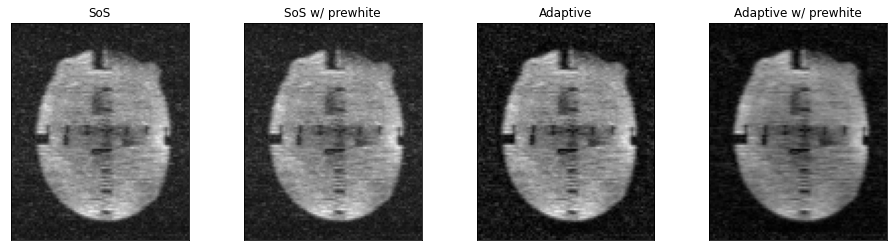

In [7]:
# Plot data
slc = 10
max_scale = 0.5
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
ax[0].set_title("SoS")
ax[0].imshow(np.abs(im_sos[:, :, slc]), cmap='gray', vmin=0, vmax=max_scale * np.max(np.abs(im_sos)))
ax[1].set_title("SoS w/ prewhite")
ax[1].imshow(np.abs(im_sos_pw[:, :, slc]), cmap='gray', vmin=0, vmax=max_scale * np.max(np.abs(im_sos_pw)))
ax[2].set_title("Adaptive")
ax[2].imshow(np.abs(im_adapt[:, :, slc]), cmap='gray', vmin=0, vmax=max_scale * np.max(np.abs(im_adapt)))
ax[3].set_title("Adaptive w/ prewhite")
ax[3].imshow(np.abs(im_adapt_pw[:, :, slc]), cmap='gray', vmin=0, vmax=max_scale * np.max(np.abs(im_adapt_pw)))
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
# fig.savefig("methods_rejection_image.tif", dpi=600, format="tiff")